In [1]:
import os
import sys
import numpy as np
import swyft
import pickle
import matplotlib.pyplot as plt
import torch
import importlib
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
torch.set_float32_matmul_precision('medium')
device_notebook = "cuda" if torch.cuda.is_available() else "cpu"
import wandb
import copy
from torch.multiprocessing import Pool
torch.multiprocessing.set_start_method('spawn',force=True)
torch.set_num_threads(28)
import itertools
import subprocess
from tqdm.auto import tqdm
sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
from explim_functions import find_false_exclusions

In [2]:
main_dir = "ALPs_with_SWYFT"
thesis_figs = os.getcwd().split(main_dir)[0]+"/"+main_dir+"/thesis_figures/"

In [47]:
names = ['flare0_agnostic','flare0_semi_informed','flare0_informed','flare0_confident1']
colors_priors = ['r','#FFA500','y','g','b', ]

priors = {}
for ip, name in enumerate(names):

    priors[name] = {'name': name}

    priors[name]['results_path'] = '/home/gertwk/ALPs_with_SWYFT/cluster_runs/analysis_results/'+name
    
    priors[name]['store_path'] = priors[name]['results_path']+"/sim_output/store"

    priors[name]['config_vars'] = priors[name]['results_path'] +'/config_variables.pickle'

    priors[name]['config_phys'] = priors[name]['results_path'] +'/physics_variables.pickle'
    
    priors[name]['truncation_record'] = priors[name]['results_path'] +'/truncation_record.pickle'

    removed_ALP_sim=0
    try:
        sys.path.remove('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')
        removed_ALP_sim=1
    except ValueError:
        pass
    try:
        del sys.modules['ALP_quick_sim']
    except KeyError:
        pass
    sys.path.append(priors[name]['results_path'])
    import param_function
    import ALP_quick_sim
    with open(priors[name]['config_vars'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['config_phys'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    with open(priors[name]['truncation_record'], 'rb') as file: config_objects = pickle.load(file)
    for key in config_objects.keys(): priors[name][key] = config_objects[key]
    sys.path.remove(priors[name]['results_path'])
    sys.path.append(priors[name]['results_path']+'/train_output/net')
    import network
    sys.path.remove(priors[name]['results_path']+'/train_output/net')
    
    count = 0
    for combo in itertools.product(*priors[name]['hyperparams'].values()):
        if count == priors[name]['which_grid_point']:
            hyperparams_point = {}
            for i, key in enumerate(priors[name]['hyperparams'].keys()):
                hyperparams_point[key]=combo[i]
        count +=1
        
    priors[name]['net_path'] = (priors[name]['results_path'] + '/train_output/net/trained_network_round_'
                                +str(priors[name]['which_truncation'])+'_gridpoint_'+str(priors[name]['which_grid_point'])+'.pt')

    priors[name]['net'] = network.NetworkCorner(nbins=priors[name]['A'].nbins, marginals=priors[name]['POI_indices'], 
                                                param_names=priors[name]['A'].param_names, **hyperparams_point)

    priors[name]['net'].load_state_dict(torch.load(priors[name]['net_path']))

    with open(priors[name]['results_path']+'/explim_predictions.pickle', 'rb') as file:
        priors[name]['predictions'] = {name: pickle.load(file)}

    if priors[name]['which_truncation'] > 0:
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior_round_"+str(priors[name]['which_truncation'])+"_gridpoint_"+str(priors[name]['which_grid_point']))
    else:
        store_explim = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_explim")
        store_prior = swyft.ZarrStore(priors[name]['store_path'] + "/" + priors[name]['store_name']+"_prior")
    priors[name]['samples_explim'] = store_explim.get_sample_store()
    priors[name]['samples_prior'] = store_prior.get_sample_store()
    
    
    del sys.modules['param_function']
    del sys.modules['ALP_quick_sim']
    del sys.modules['network']
    if removed_ALP_sim: sys.path.append('/home/gertwk/ALPs_with_SWYFT/analysis_scripts/ALP_sim')

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [4]:
trainer = swyft.SwyftTrainer(accelerator = 'cuda', precision = 64,logger=False,)

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
contour_matrices = {}
exclusion_areas = {}

In [19]:
del sys.modules['explim_functions']
from explim_functions import find_false_exclusions

In [44]:
def convert_pair_to_index(pair,n_indices):
    pair = sorted(pair)
    return int((pair[0]+1)*(n_indices-1+n_indices-pair[0]-1)/2 - n_indices + pair[1])
    
def plot_fes(prior,name_excl,name_incl,n_limits,n_prior_samples,param_pairs=[(0,1)],n_cores=4,
             ax1=None,ax2=None,line_color='b',label=None,bins=50):
    
    try:
        predictions1 = priors[name_excl]['predictions'][prior]
    except KeyError:
        try:
            with open(os.getcwd()+'/predictions-'+name_excl+'-'+prior+'.pickle', 'rb') as file: predictions1 = pickle.load(file)
        except FileNotFoundError:
            predictions1 = None
    try:
        predictions2 = priors[name_incl]['predictions'][prior]
    except KeyError:
        try:
            with open(os.getcwd()+'/predictions-'+name_incl+'-'+prior+'.pickle', 'rb') as file: predictions2 = pickle.load(file)
        except FileNotFoundError:
            predictions2 = None
    try:
        contour_matrix = contour_matrices[prior+'-'+name_excl+'-'+name_incl]
    except KeyError:
        try:
            with open(os.getcwd()+'/contour_matrix-'+prior+'-'+name_excl+'-'+name_incl+'.pickle', 'rb') as file: contour_matrix = pickle.load(file)
        except FileNotFoundError:
            contour_matrix = None
    try:
        exclusion_area = exclusion_areas[prior+'-'+name_excl+'-'+name_incl]
    except KeyError:
        try:
            with open(os.getcwd()+'/exclusion_areas-'+prior+'-'+name_excl+'-'+name_incl+'.pickle', 'rb') as file: exclusion_area = pickle.load(file)
        except FileNotFoundError:
            exclusion_area = None
    
    if ax1 is None and ax2 is None:
        fig = plt.figure(figsize=(12,6))
        fig.add_subplot(1,2,1)
        fig.add_subplot(1,2,2)
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    elif ax1 is None:
        fig = plt.figure(figsize=(6,6))
        fig.add_subplot(1,1,1)
        ax1 = fig.axes[0]
    elif ax2 is None:
        fig = plt.figure(figsize=(6,6))
        fig.add_subplot(1,1,1)
        ax2 = fig.axes[0]
    
    if __name__ == "__main__":
        
        contour_matrix,exclusion_area,predictions,_ = find_false_exclusions(
            samples = priors[prior]['samples_explim'][:n_limits],
            
            prior_samples1 = priors[name_excl]['samples_prior'][:n_prior_samples],
            predictions1=predictions1,
            net1 = priors[name_excl]['net'],
            
            prior_samples2 = priors[name_incl]['samples_prior'][:n_prior_samples],
            predictions2=predictions2,
            net2 = priors[name_incl]['net'],

            trainer = trainer,
            
            bounds = [priors[name_excl]['bounds'][0], priors[name_excl]['bounds'][1]],
            ax=ax1,
    
            contour_matrix = contour_matrix,
            false_exclusion_areas=exclusion_area,
                
            colors=['b','g','y','#FFA500','r','k'],
            
            n_cores = n_cores,
            bins=bins,
        )

        ax2.set_title(name)
        h,alpha = np.histogram(exclusion_area, bins=1+bins**2)
        ax2.plot(alpha[:-1],np.cumsum(h),color=line_color,label=label)
        if not label is None: ax2.legend()
        
        predictions[0][0] = None
        predictions[1][0] = None
        prediction_indices = []
        for pair in param_pairs:
            prediction_indices.append(convert_pair_to_index(pair, len(priors[name_excl]['POI_indices'])))
        predictions[0][1].logratios = predictions[0][1].logratios[:,prediction_indices].to(torch.float32)
        predictions[0][1].params = predictions[0][1].params[:,prediction_indices,:].to(torch.float32)
        predictions[0][1].parnames = predictions[0][1].parnames[prediction_indices]
        predictions[1][1].logratios = predictions[1][1].logratios[:,prediction_indices].to(torch.float32)
        predictions[1][1].params = predictions[1][1].params[:,prediction_indices,:].to(torch.float32)
        predictions[1][1].parnames = predictions[1][1].parnames[prediction_indices]

        priors[name_excl]['predictions'][prior] = predictions[0]
        priors[name_incl]['predictions'][prior] = predictions[1]
        contour_matrices[prior+'-'+name_excl+'-'+name_incl] = contour_matrix
        exclusion_areas[prior+'-'+name_excl+'-'+name_incl] = exclusion_area
    
        if name_excl!=prior:
            with open(os.getcwd()+'/predictions-'+name_excl+'-'+prior+'.pickle','wb') as file: pickle.dump(predictions[0], file)
        if name_incl!=prior:
            with open(os.getcwd()+'/predictions-'+name_incl+'-'+prior+'.pickle','wb') as file: pickle.dump(predictions[1], file)
        
        with open(os.getcwd()+'/contour_matrix-'+prior+'-'+name_excl+'-'+name_incl+'.pickle','wb') as file: pickle.dump(contour_matrix, file)
        with open(os.getcwd()+'/exclusion_areas-'+prior+'-'+name_excl+'-'+name_incl+'.pickle','wb') as file: pickle.dump(exclusion_area, file)
        
        # fig.savefig(thesis_figs+'false_exclusions.pdf')

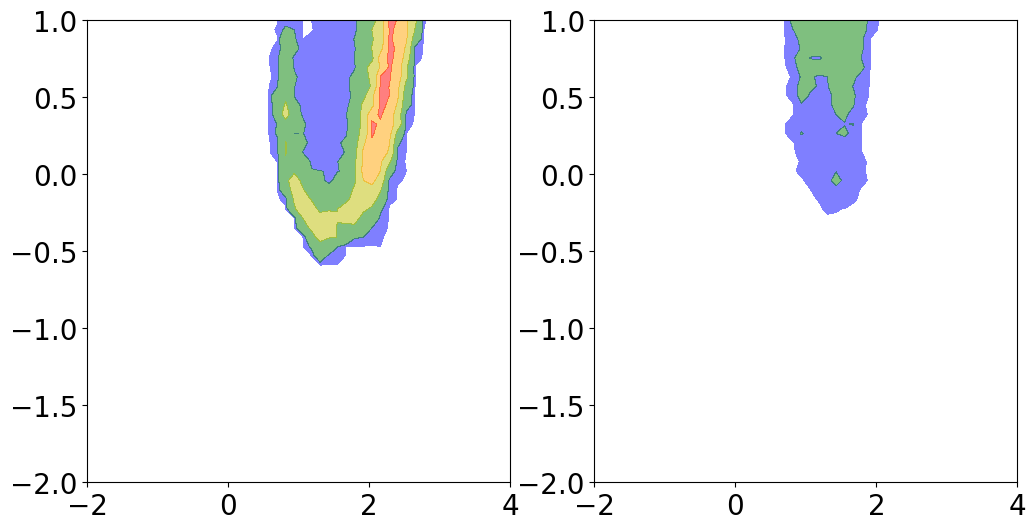

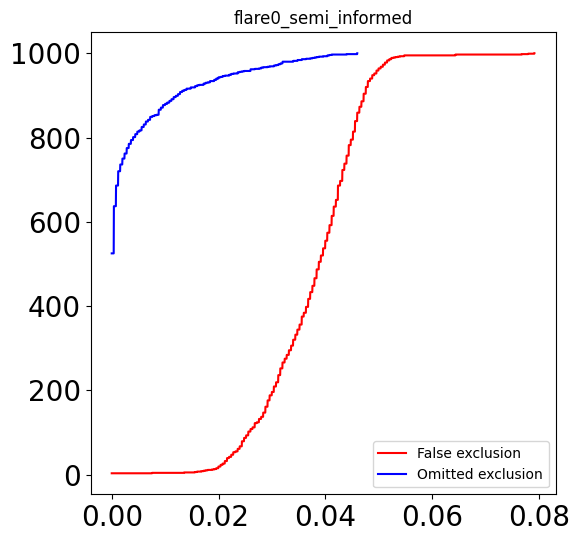

In [45]:
# priors['flare0_semi_informed']['predictions']['flare0_agnostic']=None
# contour_matrices['flare0_agnostic-flare0_semi_informed-flare0_agnostic'] = None

prior = 'flare0_agnostic'
name_excl = 'flare0_semi_informed'
name_incl = 'flare0_agnostic'

n_limits = 1000
n_prior_samples = 400_000

fig1 = plt.figure(figsize=(12,6))
fig1.add_subplot(1,2,1)
fig1.add_subplot(1,2,2)
fig2 = plt.figure(figsize=(6,6))
fig2.add_subplot(1,1,1)
ax1 = fig1.axes[0]
ax2 = fig1.axes[1]
ax3 = fig2.axes[0]

plot_fes(prior,name_excl,name_incl,n_limits,n_prior_samples,n_cores=4,ax1=ax1,ax2=ax3,line_color='r',label='False exclusion')
plot_fes(prior,name_incl,name_excl,n_limits,n_prior_samples,n_cores=4,ax1=ax2,ax2=ax3,line_color='b',label='Omitted exclusion')

In [32]:
np.max(contour_matrices[prior+'-'+name_excl+'-'+name_incl])

988.0

/home/gertwk/.conda/envs/swyft4-dev-notebook/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/gertwk/.conda/envs/swyft4-dev-notebook/lib/pyt ...
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

100%|██████████| 250/250 [15:12<00:00,  3.65s/it]


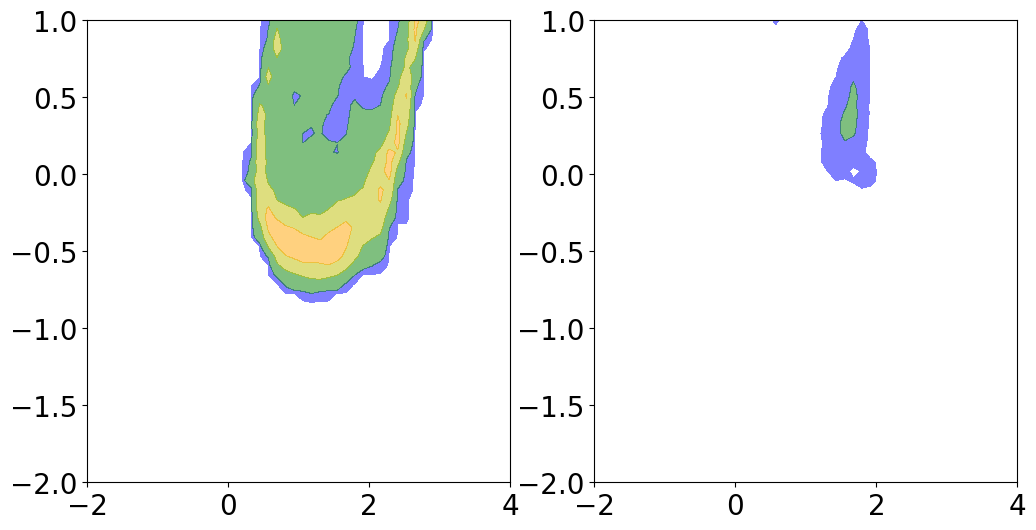

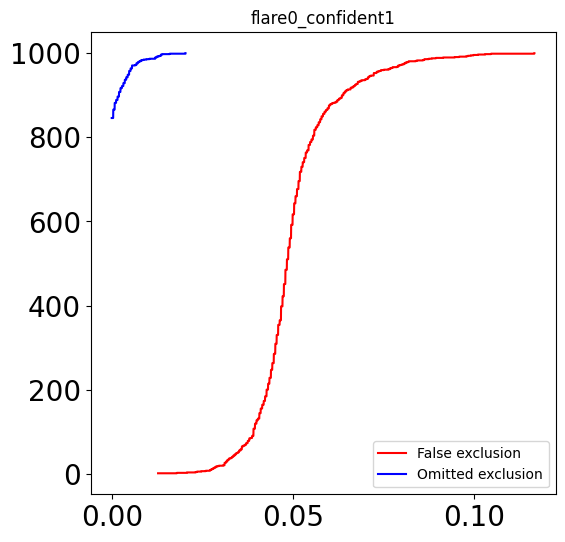

In [48]:
prior = 'flare0_informed'
name_excl = 'flare0_confident1'
name_incl = 'flare0_informed'

n_limits = 1000
n_prior_samples = 400_000

fig1 = plt.figure(figsize=(12,6))
fig1.add_subplot(1,2,1)
fig1.add_subplot(1,2,2)
fig2 = plt.figure(figsize=(6,6))
fig2.add_subplot(1,1,1)
ax1 = fig1.axes[0]
ax2 = fig1.axes[1]
ax3 = fig2.axes[0]

plot_fes(prior,name_excl,name_incl,n_limits,n_prior_samples,n_cores=4,ax1=ax1,ax2=ax3,line_color='r',label='False exclusion')
plot_fes(prior,name_incl,name_excl,n_limits,n_prior_samples,n_cores=4,ax1=ax2,ax2=ax3,line_color='b',label='Omitted exclusion')